In [1]:
import os
import h5py
import numpy as np
import openslide

In [2]:
# ChatGPT generated 
# Create an HDF5 file
with h5py.File("Bag_ID.hdf5", "w") as hdf:

    # Add metadata
    metadata_group = hdf.create_group("Metadata")
    metadata_group.attrs["ID"] = "Sample_ID"
    metadata_group.attrs["Annotation"] = "Sample slide annotation"

    # Add Tiles group
    tiles_group = hdf.create_group("Tiles")
    tiles_group.attrs["Patch size"] = 256

    # Example tile
    tile_name = "Tile0001.png"
    tile_data = np.random.rand(256, 256)  # Simulated image data
    tile_dataset = tiles_group.create_dataset(tile_name, data=tile_data)

    # Metadata for the tile
    tile_metadata_group = tiles_group.create_group(f"{tile_name}_Metadata")
    tile_metadata_group.attrs["Coordinates"] = [100, 200]
    tile_metadata_group.attrs["Annotation"] = "Tile annotation"

    # Add Preprocessing group
    preprocessing_group = hdf.create_group("Preprocessing")

    # Metadata for preprocessing
    preprocessing_group.attrs["Parameter 1"] = "Value1"
    preprocessing_group.attrs["Parameter 2"] = "Value2"

    # Example mask
    mask_data = np.random.randint(0, 2, (256, 256))  # Simulated binary mask
    preprocessing_group.create_dataset("Mask.png", data=mask_data)

    # Example annotations
    annotations = "<annotations>...</annotations>"  # XML string
    preprocessing_group.create_dataset("Annotations.xml", data=np.bytes_(annotations))


In [3]:
# Taken from: 
# https://stackoverflow.com/questions/61133916/is-there-in-python-a-single-function-that-shows-the-full-structure-of-a-hdf5-fi
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + '└── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '└── ' + key + ' (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + '├── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '├── ' + key + ' (scalar)')


In [4]:
with h5py.File("Bag_ID.hdf5", "r") as hdf:
    h5_tree(hdf)


├── Metadata
├── Preprocessing
│   ├── Annotations.xml (scalar)
│   └── Mask.png (256)
└── Tiles
    ├── Tile0001.png (256)
    └── Tile0001.png_Metadata


In [5]:
# convert CLAM output to this more self-contained, organized format! 

clam_example = "/home/felipe/Projects/multiple-instance-learning/samples/PAIP/clam-pipeline-results/patches/001100-2019-05-00-01-01.h5"

with h5py.File(clam_example, "r") as hdf:
    h5_tree(hdf)


└── coords (15537)


In [30]:
with h5py.File(clam_example, "r") as hdf:
    hdf.visit(lambda x: print(x))
    print(hdf.get("coords"))
    coords = hdf["coords"][:]
    print(coords.shape)


coords
<HDF5 dataset "coords": shape (15537, 2), type "<i8">
(15537, 2)


In [7]:
patch_size = 512
print(15537 * (patch_size)**2 / 1e9, " GB")
# this is OK since hdf5 doesn't load everything in memery (data slicing)

4.072931328  GB


In [ ]:
from openslide import open_slide

eg = open_slide("/home/felipe/Projects/multiple-instance-learning/samples/TCGA/raw/TCGA-QG-A5Z1-01Z-00-DX1.F3157C57-0F35-42D3-9CA5-C72D93F1BF89.svs")
for x, y in eg.properties.items():
    print(x, y)

In [16]:
from enum import Enum 
class FileExtension:
    JPG = "jpg"
    PNG = "png"
    SVS = "svs"
    XML = "xml"
    H5 = "h5"

In [9]:
from PIL import Image
def read_image(file_path):
    with Image.open(file_path) as img:
        img_array = np.array(img)  # Convert image to numpy array
    return img_array

In [10]:
def _fetch_clam_masks(fh, _dir, _id, ext=FileExtension.JPG):
    path = os.path.join(_dir, f"{_id}.{ext}")
    if os.path.exists(path):
        img = read_image(path)
        fh["Preprocessing"].create_dataset("Mask", data=img, compression="gzip")
        return fh 

In [11]:
def _fetch_clam_stitches(fh, _dir, _id, ext=FileExtension.JPG):
    path = os.path.join(_dir, f"{_id}.{ext}")
    if os.path.exists(path):
        img = read_image(path)
        fh["Preprocessing"].create_dataset("Stitch", data=img, compression="gzip")
        return fh 

In [80]:
from openslide import open_slide
from tqdm import tqdm

def _fetch_clam_patches(fh, _dir_patches, _dir_slides, _id, level=0, ext=FileExtension.JPG):
    # _id = fh["Metadata"].attrs["ID"] 
    
    path_patches = os.path.join(_dir_patches, f"{_id}.{FileExtension.H5}")
    # open h5 generated by clam, with (x,y) coordinates
    if os.path.exists(path_patches):
        with h5py.File(path_patches, "r") as hdf:
            coords = hdf["coords"][:]
            
    # open original slide
    path_wsi = os.path.join(_dir_slides, f"{_id}.{FileExtension.SVS}")
    wsi = open_slide(path_wsi) 
    
    # write patches to file
    count = 0
    patch_size = fh["Tiles"].attrs["Patch size"]
    for xy in tqdm(coords):
        patch = wsi.read_region(xy, level, (patch_size, patch_size))
        name = f"Tile_{count:05d}"
        count += 1
        fh["Tiles"].create_dataset(name, data=patch, compression="gzip")
        fh[f"Tiles/{name}"].attrs["Coords"] = xy
        fh[f"Tiles/{name}"].attrs["Annotation"] = 0  # TODO: see how to handle this later
    return fh 

In [81]:
def convert_clam_format(_dir, _id, ext=FileExtension.SVS):
    with h5py.File("Example.hdf5", "w") as hdf:
        # Add metadata
        metadata_group = hdf.create_group("Metadata")  # TODO: add all the desired metadata (extra stuff, not essential for now)
        metadata_group.attrs["ID"] = _id
        metadata_group.attrs["Annotation"] = 0  # TODO: see how to handle this later

        # Add Tiles group
        tiles_group = hdf.create_group("Tiles")
        tiles_group.attrs["Patch size"] = 256

        # Add Preprocessing group
        preprocessing_group = hdf.create_group("Preprocessing")

        # Metadata for preprocessing    # TODO: generate from .csv (clam output)
        preprocessing_group.attrs["Parameter 1"] = "Value1"
        preprocessing_group.attrs["Parameter 2"] = "Value2"
        
        # Fill with CLAM output data
        _fetch_clam_masks(hdf, "samples/PAIP/clam-pipeline-results/masks", _id)
        _fetch_clam_stitches(hdf, "samples/PAIP/clam-pipeline-results/stitches", _id)
        _fetch_clam_patches(hdf, "samples/PAIP/clam-pipeline-results/patches", "samples/PAIP/raw", _id)

In [82]:
convert_clam_format(None, "001400-2019-05-00-01-01")

100%|██████████| 24980/24980 [04:12<00:00, 98.81it/s] 


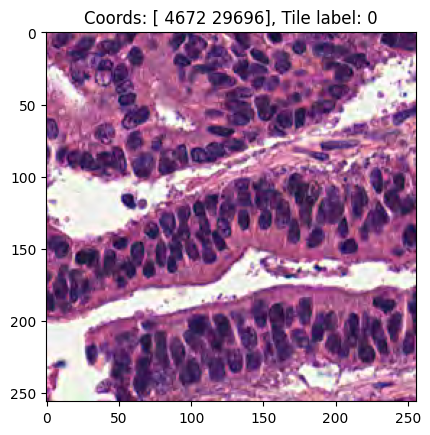

In [83]:
import matplotlib.pyplot as plt
with h5py.File("Example.hdf5", "r") as hdf:
    
    # hdf.visit(lambda x: print(x))
    
    group = hdf.get("Tiles")
    example = group["Tile_00502"][:]

    plt.imshow(example)
    plt.title(f"Coords: {group["Tile_00502"].attrs["Coords"]}, Tile label: {group["Tile_00502"].attrs["Annotation"]}")
    plt.show()  